# Titanic Survival Predicton

The objective is to predict if passanger has survived or not.

In [48]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
train = pd.read_csv(r"C:\Users\niraj\OneDrive\Desktop\DA projects\DT & RFC for Titanic Disaster Survival project\train.csv")
test = pd.read_csv(r"C:\Users\niraj\OneDrive\Desktop\DA projects\DT & RFC for Titanic Disaster Survival project\test.csv")

%matplotlib inline

In [2]:
print("Train dataset has {} samples and {} attributes".format(*train.shape))
print("Test dataset has {} samples and {} attributes".format(*test.shape))

Train dataset has 891 samples and 12 attributes
Test dataset has 418 samples and 11 attributes


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have 11 feature columns and target variable **Survived** which is binary.

Pclass, Sex and Embarked are **Categorical** Features while Age, SibSp, Parch and Fare are **continuous** variables.

We will use Name, Ticket and Cabin variable in Feature Engineering

## EDA

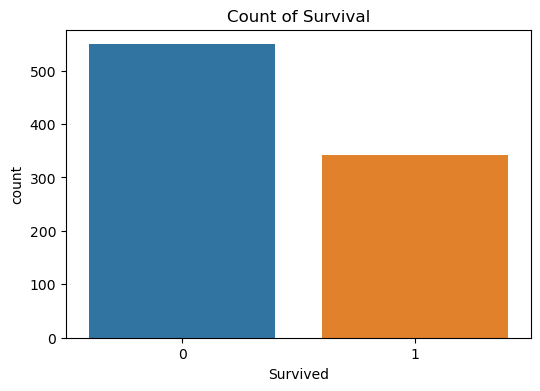

In [4]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Count of Survival")
plt.show()

In [5]:
n=len(train)
surv_0=len(train[train['Survived']==0])
surv_1=len(train[train['Survived']==1])

print("% of passanger survived in train dataset: ",surv_1*100/n)
print("% of passanger not survived in train dataset: ",surv_0*100/n)

% of passanger survived in train dataset:  38.38383838383838
% of passanger not survived in train dataset:  61.61616161616162


Passanger not survived has edge over survived passanger.  

And even if we do nothing we would get approximately 61% accuracy by simple marking all passangers as not survived(**Accuracy Paradox**). So our aim should be to get accuracy higher than this.

### Let's find correlation between Numeric Variable

In [6]:
cat=['Pclass','Sex','Embarked']
num=['Age','SibSp','Parch','Fare']

In [7]:
corr_df=train[num]  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


There's no strong correlation between any two variables. The strongest correlation is between **SibSp** and **Parch** features (0.414).

 I would like to keep all the features as there is no strong evidence of data redundancy.

Relationship between categorical variables and target variable

In [8]:
csq=chi2_contingency(pd.crosstab(train['Survived'], train['Sex']))
print("P-value: ",csq[1])

P-value:  1.1973570627755645e-58


In [9]:
csq2=chi2_contingency(pd.crosstab(train['Survived'], train['Embarked']))
print("P-value: ",csq2[1])

P-value:  1.769922284120912e-06


In [10]:
csq3=chi2_contingency(pd.crosstab(train['Survived'], train['Pclass']))
print("P-value: ",csq3[1])

P-value:  4.549251711298793e-23


P values for features Sex, Embarked and Pclass are very low. So we can reject our Null Hypothesis which is these features are independent and have no relationship with target variable

So these features contribute by providing some information.

## Visualization 

Impact of feature **Sex** on **Survived**

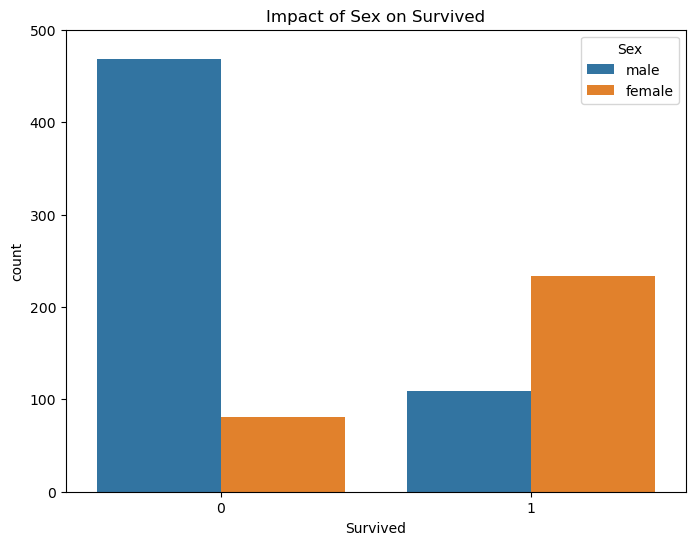

In [11]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Sex')
ax.set_ylim(0,500)
plt.title("Impact of Sex on Survived")
plt.show()

We can say that Female passangers have higher probability of survival than Male passangers

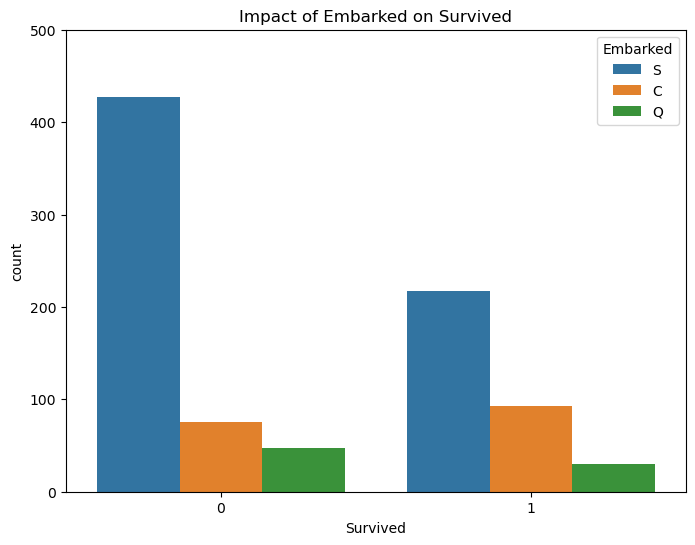

In [12]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Embarked')
ax.set_ylim(0,500)
plt.title("Impact of Embarked on Survived")
plt.show()

Ratio of Survived and Not Survived passangers for S and Q Embarked are similar but Passengers from C embarked have higer chances of survival.

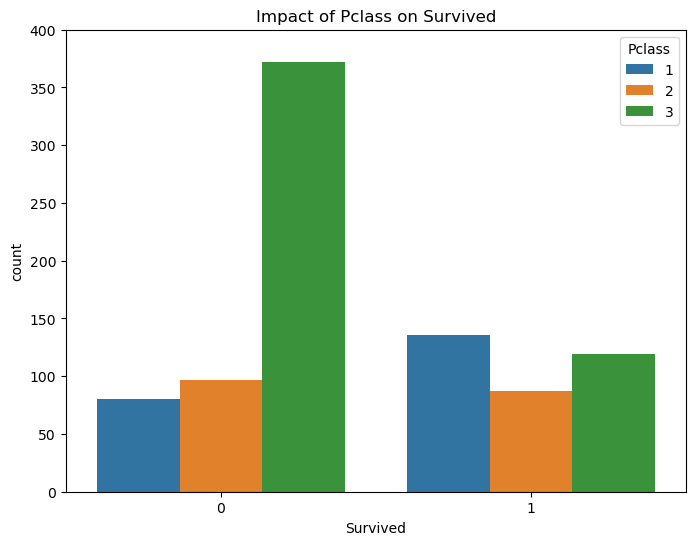

In [13]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Pclass')
ax.set_ylim(0,400)
plt.title("Impact of Pclass on Survived")
plt.show()

Passengers from **Pclass 3** have lesser chances of Survival while passengers from **Pclass 1** have higher chances of survival

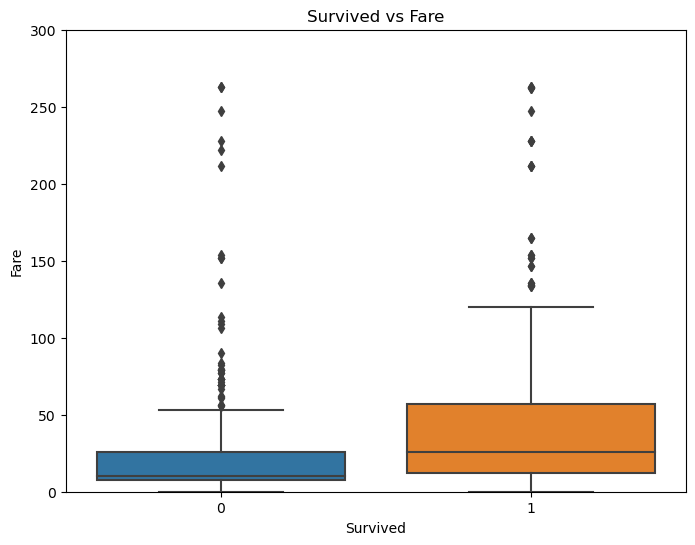

In [14]:
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Fare', data=train)
ax.set_ylim(0,300)
plt.title("Survived vs Fare")
plt.show()

Average Fare for passangers who survived is higher than not survived.

## Handling Missing Values

* Let's check which features contain missing values

In [15]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [16]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Only 4 features have missing values

#### Age

In [17]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Let's replace missing values by median of Age.

In [18]:
med=np.nanmedian(train['Age'])
train['Age']=train['Age'].fillna(med)
test['Age']=test['Age'].fillna(med)

#### Cabin

In [19]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Let's replace NaN by 0

In [20]:
train['Cabin']=train['Cabin'].fillna(0)
test['Cabin']=test['Cabin'].fillna(0)

#### Embarked****

In [21]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Let's replace the NaN by mode

In [22]:
train['Cabin']=train['Cabin'].fillna("S")

#### Fare

In [23]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [24]:
med=np.nanmedian(train['Fare'])
test['Fare']=test['Fare'].fillna(med)

## Feature Engineering

from **cabin** let's create a new feature **hasCabin** 

In [25]:
train['hasCabin']=train['Cabin'].apply(lambda x: 0 if x==0 else 1)
test['hasCabin']=test['Cabin'].apply(lambda x: 0 if x==0 else 1)

Let's combine SibSp and Parch features to create new one **FamilyMem**

In [26]:
train['FamilyMem']=train.apply(lambda x: x['SibSp']+x['Parch'], axis=1)
test['FamilyMem']=test.apply(lambda x: x['SibSp']+x['Parch'], axis=1)

Let's use prefixes in the name to Create a new column **Title** 

In [27]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [28]:
train['title']=train['Name'].apply(get_title)
test['title']=test['Name'].apply(get_title)

In [29]:
title_lev1=list(train['title'].value_counts().reset_index()['index'])
title_lev2=list(test['title'].value_counts().reset_index()['index'])

In [30]:
title_lev=list(set().union(title_lev1, title_lev2))
print(title_lev)

['Lady', 'Rev', 'Jonkheer', 'Master', 'Col', 'Capt', 'Dona', 'Mme', 'Mr', 'Ms', 'Major', 'Sir', 'Mrs', 'Dr', 'Miss', 'Mlle', 'Countess', 'Don']


### Assigning datatypes

In [31]:
train['title']=pd.Categorical(train['title'], categories=title_lev)
test['title']=pd.Categorical(test['title'], categories=title_lev)

In [32]:
cols=['Pclass','Sex','Embarked','hasCabin','title']
fcol=['Pclass','Sex','Embarked','hasCabin','title','Age','FamilyMem','Fare']

In [33]:
for c in cols:
    train[c]=train[c].astype('category')
    test[c]=test[c].astype('category')

###  Let's create dummy variables

In [34]:
train_df=train[fcol]
test_df=test[fcol]

In [35]:
train_df=pd.get_dummies(train_df, columns=cols, drop_first=True)
test_df=pd.get_dummies(test_df, columns=cols, drop_first=True)

In [36]:
y=train['Survived']

## Model

In [37]:
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=42)

### Random Forest

In [38]:
rfc=RandomForestClassifier(random_state=42)

In [39]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [40]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [41]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 200}

In [42]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [43]:
rfc1.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [44]:
pred=rfc1.predict(x_test)

In [45]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8059701492537313


In [49]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[137  20]
 [ 32  79]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.80      0.71      0.75       111

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268

